In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from model import BiLSTM, AttentionBiLSTM
from dataset import News
from embedding import GloVe
from train import evaluate
from utils import load_config, load_checkpoint, load_history, predictions2labels, plot

<h1>Setup</h1>

In [2]:
path = "data"
labels = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}
config = load_config()
checkpoints = {
    "BiLSTM": load_checkpoint("assets/checkpoint_bilstm.pt"),
    "Multi-BiLSTM": load_checkpoint("assets/checkpoint_multi-bilstm.pt"),
    "Attention-BiLSTM": load_checkpoint("assets/checkpoint_attention-bilstm.pt"),
    "Multi-Attention-BiLSTM": load_checkpoint("assets/checkpoint_attention-multi-bilstm.pt"),
}
glove = GloVe(**config['GloVe'])

In [3]:
models = {
    "BiLSTM": BiLSTM(glove, **config['BiLSTM']),
    "Multi-BiLSTM": BiLSTM(glove, **config['Multi-BiLSTM']),
    "Attention-BiLSTM": AttentionBiLSTM(glove, **config['Attention-BiLSTM']),
    "Multi-Attention-BiLSTM": AttentionBiLSTM(glove, **config['Multi-Attention-BiLSTM']),
}

In [4]:
for model in models:
    models[model].load_state_dict(checkpoints[model]['model_state_dict'])

In [5]:
test_dataset = News(path, glove, split="test")
test_dataloader = DataLoader(test_dataset, collate_fn=test_dataset.collate_fn, **config['test'])

<h1>Model Training</h1>

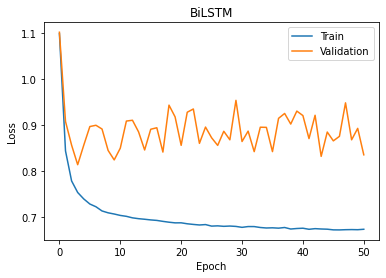

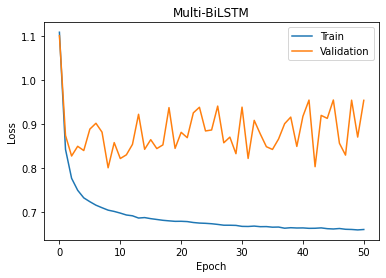

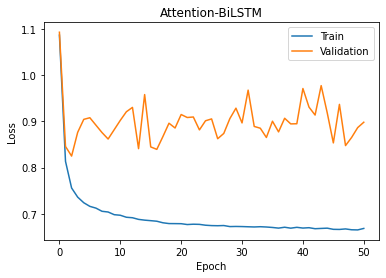

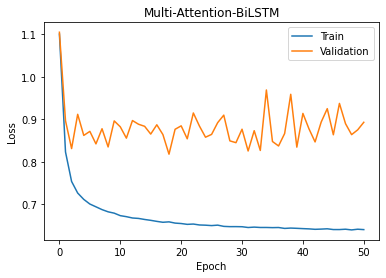

In [6]:
histories = {
    "BiLSTM": load_history("assets/history_bilstm.pkl"),
    "Multi-BiLSTM": load_history("assets/history_multi-bilstm.pkl"),
    "Attention-BiLSTM": load_history("assets/history_attention-bilstm.pkl"),
    "Multi-Attention-BiLSTM": load_history("assets/history_attention-multi-bilstm.pkl")   
}
for model in histories:
    losses = [histories[model]['train']['loss'], histories[model]['val']['loss']]
    epochs = [list(range(len(histories[model]['train']['loss']))), list(range(len(histories[model]['val']['loss'])))]
    legends = ["Train", "Validation"]
    title = model
    plot(epochs, losses, legends, title)

<h1>Model Evaluation</h1>

In [7]:
results = dict()
for model in models:
    loss, accuracy = evaluate(models[model], test_dataloader)
    results.update({
        model: accuracy
    })

In [8]:
print(f"{'Model':<30}{'Accuracy':<8}")
for model in results:
    print(f"{model:<30}{results[model]:<8}")

Model                         Accuracy
BiLSTM                        0.604   
Multi-BiLSTM                  0.603   
Attention-BiLSTM              0.617   
Multi-Attention-BiLSTM        0.613   


<h1>Model Inference</h1>

<h2>Batch</h2>

In [9]:
sentences, sentiments = next(iter(test_dataloader))
bilstm = models['BiLSTM']
logits = bilstm(sentences)
predictions = torch.argmax(F.softmax(logits, dim=-1), dim=-1).detach().cpu().numpy()
sentiments = sentiments.detach().cpu().numpy()
predictions = predictions2labels(predictions, labels)
sentiments = predictions2labels(sentiments, labels)

In [10]:
print(f"{'Sentence':<100}{'Actual':<10}{'Predicted':<10}")
for i in range(len(predictions)):
    sentence = " ".join(test_dataset[i][0])
    print(f"{sentence:<100}{sentiments[i]:<10}{predictions[i]:<10}")

Sentence                                                                                            Actual    Predicted 
buzz : malaysia 's hengyuan sells light naphtha to oil major                                        Positive  Neutral   
fgv 's cfo ahmad tifli has replied to show-cause letter , remains on leave of absence               Negative  Neutral   
fgv 's ceo zakaria gets extension till tomorrow to reply to show cause letter                       Negative  Neutral   
4 key demographics and 5 investment themes for asia                                                 Neutral   Positive  
only pin and pay for insurance premium payment from july 1 - liam                                   Neutral   Neutral   
sme bank sees 40 % jump in pbt ; md mohd radzif to vacate post                                      Positive  Positive  
cover story : fgv in turmoil - zakaria says : i should quit over an internal audit ?                Negative  Neutral   
cover story : fgv in turmoil - i

<h2>Individual</h2>

In [11]:
sentence = "close to half of malaysian women quit work due to halt in career progression"
prediction = bilstm.inference(sentence).item()
prediction = labels[prediction]
print(f"{'Sentence':<100}{'Predicted':<10}")
print(f"{sentence:<100}{prediction:<10}")

Sentence                                                                                            Predicted 
close to half of malaysian women quit work due to halt in career progression                        Negative  
